In [1]:
# inspired from: A deep understanding of deep learning



import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset


from sklearn.model_selection import train_test_split




import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


# %matplotlib widget
%matplotlib notebook
%matplotlib inline


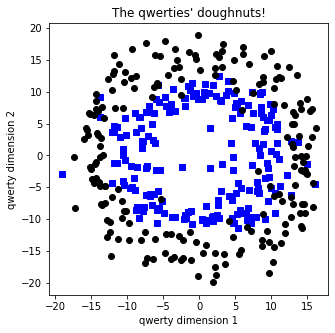

In [2]:
nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

data_np = np.hstack((a,b)).T


data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()



fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


batchsize    = 16 #int(train_data.tensors[0].shape[0]/4) -- Hard-coding is better to avoid huge batches!
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
class theModelClass(nn.Module):

  def __init__(self,dropoutRate):
    super().__init__()

    self.input  = nn.Linear(  2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128, 1)

    self.dr = dropoutRate



  def forward(self,x):

    x = F.relu( self.input(x) )

    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    
    x = F.relu( self.hidden(x) )

    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    
    x = self.output(x)


    return x


    

In [5]:
tmpnet = theModelClass(.25)

tmpdata = torch.randn((10,2))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.0205],
        [-0.1299],
        [-0.1429],
        [-0.0611],
        [-0.0403],
        [ 0.0192],
        [-0.0856],
        [-0.0933],
        [-0.1558],
        [-0.2493]], grad_fn=<AddmmBackward0>)

In [6]:
def createANewModel(dropoutrate):

  ANNQC = theModelClass(dropoutrate)

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.002)

  return ANNQC,lossfun,optimizer

  

In [7]:
numepochs = 1000


def trainTheModel(ANNQC,lossfun,optimizer):

  trainAcc = []
  testAcc  = []


  for epochi in range(numepochs):

    ANNQC.train() 

    batchAcc = []
    for X,y in train_loader:

      yHat = ANNQC(X)
      loss = lossfun(yHat,y)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )

    trainAcc.append( np.mean(batchAcc) )


    ANNQC.eval()
    X,y = next(iter(test_loader))
    yHat = ANNQC(X)
    testAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
  


  return trainAcc,testAcc



In [8]:
dropoutrate = .0
ANNQC,lossfun,optimizer = createANewModel(dropoutrate)

trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

In [9]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

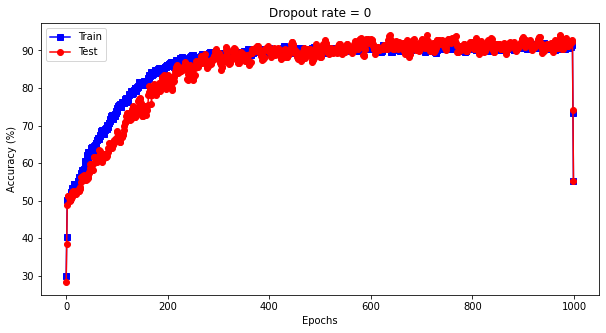

In [10]:
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

In [11]:
# run an experiment (note: takes ~3.5 mins)

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  ANNQC,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

  # store accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])


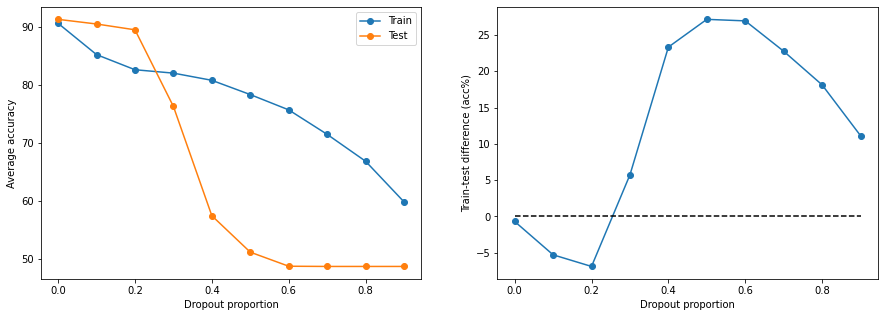

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()